# Parallelisation and GPU Hardware acceleration

## Single Thread

In [1]:
import numba as nb
import numpy as np

In [81]:
@nb.njit(parallel=False)
def st_g_series(factor, ammount, start):
    _output = np.zeros(ammount)
    for i in nb.prange(ammount):
        for _ in range(i+start):
            _output[i] += factor ** _
    return _output

In [82]:
%%time
result_st = st_g_series(0.9,100,1) # 100,000

Wall time: 77.3 ms


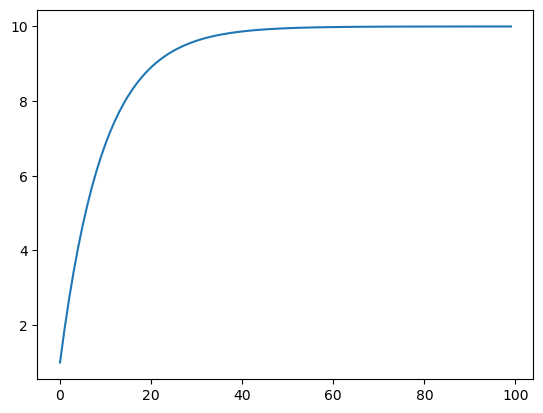

In [83]:
import matplotlib.pyplot as plt
plt.plot(result_st)
plt.show()

### Optimized

In [87]:
@nb.njit(parallel=False)
def st_g_series_op(factor, ammount, start=1):
    _output = np.zeros(ammount)
    for i in range(start):
        _output[0] += (factor ** i)
    for i in nb.prange(ammount-1):
        _output[i+1] = _output[i] + ( factor ** (i+start) )
    return _output

In [88]:
%%time
result_op = st_g_series_op(0.9,100,1) # 100,000

Wall time: 94.2 ms


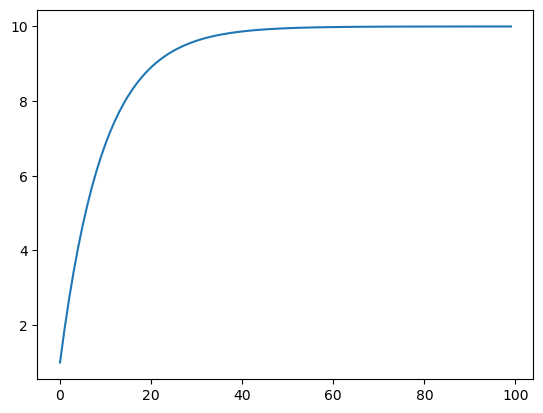

In [89]:
import matplotlib.pyplot as plt
plt.plot(result_op)
plt.show()

## Multi-Threaded

In [24]:
import numba as nb
import numpy as np

In [25]:
nb.get_num_threads()

24

In [26]:
@nb.njit(parallel=True)
def mt_g_series(factor, ammount, start):
    _output = np.zeros(ammount)
    for i in nb.prange(ammount):
        for _ in range(i+start):
            _output[i] += factor ** _
    return _output

In [27]:
%%time
result_mt = mt_g_series(0.9,100_000,1) # 100,000

Wall time: 19.7 s


In [ ]:
import matplotlib.pyplot as plt
plt.plot(result_mt)
plt.show()

## GPU Parallel

In [72]:
import numpy as np
import numba.cuda as cuda

In [73]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3080 Ti'                              [SUPPORTED]
                      Compute Capability: 8.6
                           PCI Device ID: 0
                              PCI Bus ID: 10
                                    UUID: GPU-d9754c71-3054-9ff7-9a61-3fa38787bca2
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [74]:
@cuda.jit
def gpu_g_calc(_output, factor, start):
    pos = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if pos < _output.size:
        for _ in range(pos+start):
            _output[pos] += factor ** _

In [75]:
ammount = 100_000 # 100,000
dev_c = cuda.device_array((ammount,), np.float64)
threadsperblock = 32
blockspergrid = (ammount + (threadsperblock - 1)) // threadsperblock

In [76]:
%%time
gpu_g_calc[blockspergrid, threadsperblock]( dev_c,0.9,1)
result_cd = dev_c.copy_to_host() # 1,

Wall time: 1.19 s


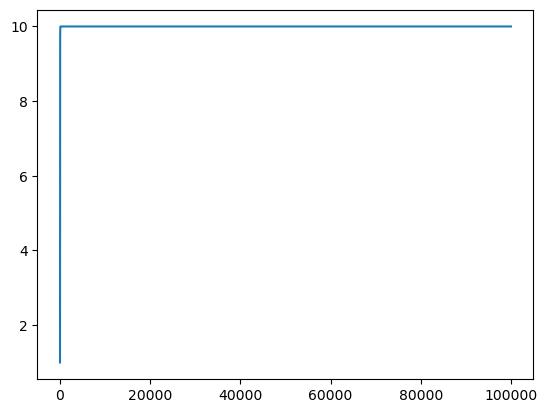

In [77]:
import matplotlib.pyplot as plt
plt.plot(result_cd)
plt.show()

In [6]:
ammount = 1_000_000 # 1,000,000
dev_c = cuda.device_array((ammount,), np.float64)
threadsperblock = 32
blockspergrid = (ammount + (threadsperblock - 1)) // threadsperblock

In [5]:
%%time
gpu_g_calc[blockspergrid, threadsperblock]( dev_c,1.00000001,1)
result = dev_c.copy_to_host()

Wall time: 2min 36s


In [64]:
0.9 ** 1

0.9